# Here I will explore the resonance transistion Eigansolver descirbed here:

https://arxiv.org/pdf/1706.08644.pdf

In [1]:
from qiskit import quantum_info as qi
import numpy as np
import pandas as pd
import numpy.linalg as lng
import random as rnd
pd.options.display.float_format = '{:,.1f}'.format

C:\Users\jsten\Anaconda3\envs\new_qiskit\lib\site-packages\qiskit\__init__.py:62: RuntimeWarning: Could not import the Aer provider from the qiskit-aer package. Install qiskit-aer or check your installation.
  warnings.warn('Could not import the Aer provider from the qiskit-aer '
C:\Users\jsten\Anaconda3\envs\new_qiskit\lib\site-packages\qiskit\__init__.py:72: RuntimeWarning: Could not import the IBMQ provider from the qiskit-ibmq-provider package. Install qiskit-ibmq-provider or check your installation.
  warnings.warn('Could not import the IBMQ provider from the '


In [2]:
def I0(L):
    label = ""
    for i in range(0,L):
        label += "I"
    return qi.Operator.from_label(label).data

def X(l,L):
    label = ""
    for i in range(0,l):
        label += "I"
    label += "X"
    for i in range(l+1,L):
        label += "I"
    return qi.Operator.from_label(label).data

def Y(l,L):
    label = ""
    for i in range(0,l):
        label += "I"
    label += "Y"
    for i in range(l+1,L):
        label += "I"
    return qi.Operator.from_label(label).data

def Z(l,L):
    label = ""
    for i in range(0,l):
        label += "I"
    label += "Z"
    for i in range(l+1,L):
        label += "I"
    return qi.Operator.from_label(label).data
    
def gx(l,L):
    label = ""
    for i in range(0,l):
        label += "Z"
    label += "X"
    for i in range(l+1,L):
        label += "I"
    return qi.Operator.from_label(label).data

def gy(l,L):
    label = ""
    for i in range(0,l):
        label += "Z"
    label += "Y"
    for i in range(l+1,L):
        label += "I"
    return qi.Operator.from_label(label).data

def cd(l,L):
    return 1/2*(gx(l,L)+1j*gy(l,L))

def c(l,L):
    return 1/2*(gx(l,L)-1j*gy(l,L))

In [3]:
def bkt(psi_a,U,psi_b):
    return np.dot(np.conjugate(psi_a),np.dot(U,psi_b))

def Mdot(Ol):
    m = Ol[0]
    for i in range(1,len(Ol)):
        m = np.dot(Ol[i],m)
    return m

In [4]:
mu = 0.3
t = -0.7

H0 = mu*(Mdot([cd(0,2),c(0,2)]) + Mdot([cd(1,2),c(1,2)])) + t*(Mdot([cd(0,2),c(1,2)]) + Mdot([cd(1,2),c(0,2)]))

In [250]:
print(pd.DataFrame(H0))
e0,y0 = lng.eig(H0)
psi0 = np.conjugate(np.transpose(y0))
print(e0)
psi0[1]

         0         1         2        3
0 0.0+0.0j  0.0+0.0j  0.0+0.0j 0.0+0.0j
1 0.0+0.0j  0.3+0.0j -0.7+0.0j 0.0+0.0j
2 0.0+0.0j -0.7+0.0j  0.3+0.0j 0.0+0.0j
3 0.0+0.0j  0.0+0.0j  0.0+0.0j 0.6+0.0j
[ 1. +0.j -0.4+0.j  0. +0.j  0.6+0.j]


array([0.        -0.j, 0.70710678-0.j, 0.70710678-0.j, 0.        -0.j])

In [352]:
def Hb(w):
    return 1/2*w*Z(2,3)

#Note: There must be an asymmetery in qubit coupling to see both peaks
def Hx(Cx):
    A = Cx*(Mdot([cd(0,3),X(2,3)])+Mdot([X(2,3),c(0,3)])+0.3*Mdot([cd(1,3),X(2,3)])+0.3*Mdot([X(2,3),c(1,3)]))
    #B = 2.7*Cx*(Mdot([cd(0,3),cd(1,3),X(2,3)])+Mdot([c(1,3),c(0,3),X(2,3)]))
    return A

def H(cx, w):
    return np.kron(H0,I0(1))+Hb(w)+Hx(cx)

In [353]:


#print(np.amax(np.abs(Mdot([psi,eD,psi_d])-H)))

def U(cx,w,t):
    e,psi_d = lng.eig(H(cx,w))
    psi = np.conjugate(np.transpose(psi_d))
    eD = np.diag(e)
    exp = np.exp(1j*e*t)
    expD = np.diag(exp)
    return Mdot([psi,expD,psi_d])

n=1;
w=0.3
t=0.8
cx=0.3
e,psi_d = lng.eig(H(cx,w))
psi = np.conjugate(np.transpose(psi_d))
eD = np.diag(e)
bkt(psi[n],U(cx,w,t),psi[n])-np.exp(1j*e[n]*t)

(1.1102230246251565e-16+1.1102230246251565e-16j)

In [354]:

def measure(psi):
    P = bkt(psi,Z(2,3),psi)
    P0=(1+P)/2
    P1=(1-P)/2
    m = rnd.choices([1,-1],weights = [P0,P1])[0]
    Project = np.kron(I0(2),1/2*(I0(1)+m*Z(0,1)))
    psi = Mdot([Project,psi])
    norm = np.sqrt(bkt(psi,I0(3),psi))
    psi = psi/norm
    return m,psi



In [355]:
def step(psi,cx,w,t):
    psi = Mdot([U(cx,w,t),psi])
    m,psi = measure(psi)
    return m,psi

In [364]:
import copy 

psiA = np.sqrt(0.2)*qi.Statevector.from_label('-+1').data ++np.sqrt(0.7)*qi.Statevector.from_label('+-1').data + np.sqrt(0.3)*qi.Statevector.from_label('++1').data
psiA = psiA/np.sqrt(bkt(psiA,I0(3),psiA))
wl = [wi*0.01 for wi in range(0,300)]

t = 200.0
cx = 0.01
Ns = 100
pl = []
for w in wl:
    psiS = psiA
    psiS = Mdot([U(cx,w,t),psiS])
    pw = bkt(psiS,Z(2,3),psiS)

    pl.append(pw)

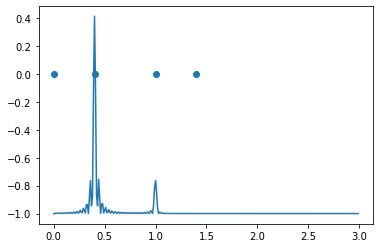

In [365]:
import matplotlib.pyplot as plt

marker = [0 for i in e0]
gt = [e0[i]-e0[1] for i in range(0,len(e0))]

plt.plot(wl,pl)
plt.scatter(gt,marker)
plt.show()

In [366]:
import copy 

psiA = np.sqrt(0.7)*qi.Statevector.from_label('+-1').data + np.sqrt(0.3)*qi.Statevector.from_label('++1').data
wl = [wi*0.1 for wi in range(0,30)]

t = 200.0
cx = 0.01
Ns = 100
pl = []
for w in wl:
    pw = []
    for s in range(0,Ns):
        psiS = psiA
        m,psi = step(psiS,cx,w,t)
        pw.append(m)

    pl.append(sum(pw)/Ns)

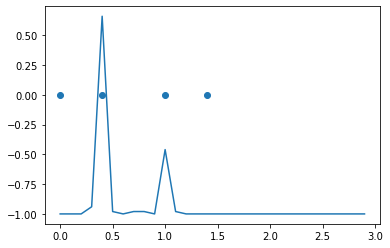

In [367]:
plt.plot(wl,pl)
plt.scatter(gt,marker)
plt.show()

## Now let us switch to the two qubit register used for ground state preperation

In [463]:
Hb =-1/2*Z(0,4)

def Hx(cx):
    return cx*(Mdot([X(0,4),X(1,4)])) 

def HR(w):
    w0 = w+1
    return (w0*I0(3)+w0*Z(0,3)+np.kron(I0(1),H0)-np.kron(Z(0,1),H0))/2

def H(cx,w):
    return Hb + Hx(cx) + np.kron(I0(1),HR(w))
    

In [464]:
def U(cx,w,t):
    e,psi_d = lng.eig(H(cx,w))
    psi = np.conjugate(np.transpose(psi_d))
    eD = np.diag(e)
    exp = np.exp(1j*e*t)
    expD = np.diag(exp)
    return Mdot([psi,expD,psi_d])

#Check U
n=1;
w=0.3
t=0.8
cx=0.3
e,psi_d = lng.eig(H(cx,w))
psi = np.conjugate(np.transpose(psi_d))
eD = np.diag(e)
bkt(psi[n],U(cx,w,t),psi[n])-np.exp(1j*e[n]*t)

(1.1102230246251565e-16+2.7755575615628914e-17j)

### Find the energy

In [467]:
psiA = np.sqrt(0.2)*qi.Statevector.from_label('00-+').data ++np.sqrt(0.7)*qi.Statevector.from_label('00+-').data + np.sqrt(0.3)*qi.Statevector.from_label('00++').data
psiA = psiA/np.sqrt(bkt(psiA,I0(4),psiA))
wl = [wi*0.01-1 for wi in range(0,300)]

t = 200.0
cx = 0.01
Ns = 100
pl = []
for w in wl:
    psiS = psiA
    psiS = Mdot([U(cx,w,t),psiS])
    pw = bkt(psiS,Z(0,4),psiS)

    pl.append(pw)

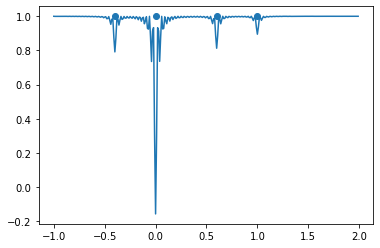

In [469]:
marker = [1 for i in e0]

plt.plot(wl,pl)
plt.scatter(e0,marker)
plt.show()

### Find the ground state

In [475]:
def measure(psi):
    P = bkt(psi,Z(0,4),psi)
    P0=(1+P)/2
    P1=(1-P)/2
    m = rnd.choices([1,-1],weights = [P0,P1])[0]
    Project = I0(4)+m*Z(0,4)
    psi = Mdot([Project,psi])
    norm = np.sqrt(bkt(psi,I0(4),psi))
    psi = psi/norm
    return m,psi

In [476]:
psiA = np.sqrt(0.2)*qi.Statevector.from_label('00-+').data ++np.sqrt(0.7)*qi.Statevector.from_label('00+-').data + np.sqrt(0.3)*qi.Statevector.from_label('00++').data
psiA = psiA/np.sqrt(bkt(psiA,I0(4),psiA))

t = 200.0
cx = 0.01
Nk = 50
pl = []
psiS = psiA
k = 0
while k < Nk:
    psiW = psiS
    psiW = Mdot([U(cx,e0[1],t),psiW])
    m,psiM = measure(psiW)
    if m > 0.9999:
        k = k+1
        psiS = Mdot([X(0,4),X(1,4),psiM])




In [491]:
psi0C = np.kron([0,0,0,1],psi0[1])
np.abs(bkt(psiS,I0(4),psi0C))**2

1.0000000000000004

In [492]:
pwd

'C:\\Users\\jsten\\IBMQ\\Explorations'